## Part 2 of the Data Science challenge.
#### Create a tool that visualises different metrics for different search results on Twitter

In [1]:
import tweepy 
import pandas as pd
import requests
import json

In [2]:
def authorize_twitter_api():
    '''read auth keys and secrets for my twitter app, returning authorized api for use to make requests'''
    base_path = "/home/adrian/test/Kahoot-challenge/keys/"
    with open(base_path + "consumer_key.txt") as f:
        consumer_key = f.readline().strip()
    with open(base_path + "consumer_secret.txt") as f:
        consumer_secret = f.readline().strip()
    with open(base_path + "access_token.txt") as f:
        access_token = f.readline().strip()
    with open(base_path + "access_token_secret.txt") as f:
        access_token_secret = f.readline().strip()
        
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    
    return tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)
    

In [14]:
def get_bearer_token():
    base_path = "/home/adrian/test/Kahoot-challenge/keys/"
    with open(base_path + "bearer_token.txt") as f:
        return f.readline().strip()

In [38]:
bearer_token = get_bearer_token()
search_count_url = "https://api.twitter.com/2/tweets/counts/recent"
search_url = "https://api.twitter.com/2/tweets/search/recent"

In [42]:
def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentTweetCountsPython,v2RecentSearchPython"
    return r

def bearer_search_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentTweetCountsPython"
    return r


def connect_to_endpoint(url, params):
    response = requests.request("GET", url, auth=bearer_oauth, params=params)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()


In [77]:
# Optional params: start_time,end_time,since_id,until_id,next_token,granularity
query_count_params = {'query': 'kahoot','granularity': 'minute'}
query_count_object = connect_to_endpoint(search_count_url, query_count_params)

Comment: spent way too much time converting to a date object that is filterable, the localize "property" of the datetime object ruined quite a bit. Found that there is a two hour difference between the data from twitter and my current time, therefore using the 5,10,15 minutes and 2 hours back in time when filtering..

In [78]:
'''make dataframe out of query count numbers, and convert from string to timestamps'''
df_query_count = pd.DataFrame(query_count_object["data"], columns=["start","end","tweet_count"])
df_query_count.loc[:,"start"] = pd.to_datetime(df_query_count.loc[:,"start"],utc=True)
df_query_count.loc[:,"end"] = pd.to_datetime(df_query_count.loc[:,"end"],utc=True)
 

In [380]:
'''Get the search counts for the query, 1 minute, 5 minutes, 15 minutes ago and total hits'''
time_steps = [1,5,15]
query_count = {}
timezone_delay = 120
for minutes_ago in time_steps:
    time_delta = pd.to_datetime('today') - pd.Timedelta(120 + minutes_ago, 'minutes')
    query_count[str(minutes_ago) + " minutes ago"] = df_query_count[df_query_count["start"] >= time_delta.tz_localize('UTC')].tweet_count.sum()    
query_count["total"] = query_count_object["meta"]["total_tweet_count"]

In [381]:
query_count

{'1 minutes ago': 0, '5 minutes ago': 0, '15 minutes ago': 0, 'total': 6264}

In [422]:
#hack to get RFC 3339 timestamp as required by twitter
start_time = pd.to_datetime('today') - pd.Timedelta(120 + 15, 'minutes')
start_time = start_time.isoformat("T")+"Z"

# Optional params: start_time,end_time,since_id,until_id,max_results,next_token,
# expansions,tweet.fields,media.fields,poll.fields,place.fields,user.fields
search_term = "hello world"
query_search_params = {'query': search_term,'tweet.fields': 'author_id,created_at','max_results':'100', 'start_time':start_time}


In [423]:
'''
Due to limitations in results for each request from API, pagination needs to be implemented. Using next_token for this.
Will only iterate through the 1000 first results, as this should be more than enough to illustrate proof of concept
'''
tweets = []
for i in range(100,1001,100):
    query_search_object = connect_to_endpoint(search_url, query_search_params)
    tweets.extend(query_search_object["data"])
    try: 
        next_token = query_search_object["meta"]['next_token']
        query_search_params["next_token"] = query_search_object["meta"]["next_token"]
    except:
        #no more content, exit loop
        break
    

In [424]:
len(tweets)

105

In [425]:
tweets

[{'text': 'RT @ArianaGrande: hello @nbcthevoice can september 20th hurry up please ? i love my #teamariana and i am waiting quite impatiently to be ab…',
  'id': '1427893198861443075',
  'author_id': '895644422859141120',
  'created_at': '2021-08-18T07:20:42.000Z'},
 {'text': "Hello. I am carol. Don't you want to find delicious cuisine with me around the world? I am in Spain🇪🇸. The weather now is ☁️☁️☁️☁️⛅️☁️☁️☁️☁️☁️🌧. \n\n I am so excited to eat🍘🍸🍧",
  'id': '1427893182528884736',
  'author_id': '1114684320868732929',
  'created_at': '2021-08-18T07:20:38.000Z'},
 {'text': 'RT @iKON_INTL: [Stan World Event]\n\nHello iKONICS!\n\nStan World will start tomorrow, Aug 19 - 11 AM KST. Download Stan World App now. Tweet w…',
  'id': '1427893165286051843',
  'author_id': '1382336957053865987',
  'created_at': '2021-08-18T07:20:34.000Z'},
 {'text': 'RT @iKON_INTL: [Stan World Event]\n\nHello iKONICS!\n\nStan World will start tomorrow, Aug 19 - 11 AM KST. Download Stan World App now. Tweet w…',


In [426]:
df_tweets = pd.DataFrame(tweets)
df_tweets["created_at"] = pd.to_datetime(df_tweets.loc[:,"created_at"],utc=True)

In [427]:
from sklearn.feature_extraction.text import CountVectorizer

In [428]:
def get_most_frequent_words(query_word, corpus,n_words):
    '''
    Returns the most frequently used words from the input corpus. 
    Removes punctuation and english stop words. 
    Removing english stop words can be a weakness in some analytical tasks, and should be considered further.
    '''
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(df_tweets.text.values)
    
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items() if word != query_word]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n_words]

In [429]:
frequent_terms = {}
for minutes_ago in time_steps:
    time_delta = pd.to_datetime('today') - pd.Timedelta(120 + minutes_ago, 'minutes')
    frequent_terms[str(minutes_ago) + " minutes ago"] = get_most_frequent_words(search_term,df_tweets[df_tweets["created_at"] >= time_delta.tz_localize('UTC')].text.values, 10)  

In [430]:
frequent_terms

{'1 minutes ago': [('world', 187),
  ('stan', 140),
  ('hello', 101),
  ('rt', 86),
  ('ikon_intl', 47),
  ('ikonics', 47),
  ('download', 47),
  ('app', 47),
  ('event', 42),
  ('start', 42)],
 '5 minutes ago': [('world', 187),
  ('stan', 140),
  ('hello', 101),
  ('rt', 86),
  ('ikon_intl', 47),
  ('ikonics', 47),
  ('download', 47),
  ('app', 47),
  ('event', 42),
  ('start', 42)],
 '15 minutes ago': [('world', 187),
  ('stan', 140),
  ('hello', 101),
  ('rt', 86),
  ('ikon_intl', 47),
  ('ikonics', 47),
  ('download', 47),
  ('app', 47),
  ('event', 42),
  ('start', 42)]}

In [431]:
import matplotlib.pyplot as plt


/home/adrian/miniconda3/envs/dataVisualization/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/adrian/miniconda3/envs/dataVisualization/lib/python3.8/site-packages/seaborn/distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/adrian/miniconda3/envs/dataVisualization/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/adrian/miniconda3/envs/dataVisualization/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/adrian/miniconda3/envs/dataVisualizatio

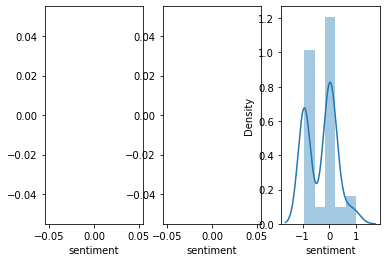

In [439]:
'''Filters the tweet dataframe by tweets created the last '''
from textblob import TextBlob
from collections import Counter
top_tweepers = {}
sentiment = {}
fig, axes = plt.subplots(ncols=3, nrows=1)
for i, minutes_ago  in enumerate(time_steps):
    time_delta = pd.to_datetime('today') - pd.Timedelta(120 + minutes_ago, 'minutes')
    tmp_df = df_tweets[df_tweets["created_at"] >= time_delta.tz_localize('UTC')]
    top_tweepers[str(minutes_ago) + " minutes ago"] = Counter(tmp_df.author_id).most_common(10)  
    tmp_df.loc[:,["sentiment"]] = tmp_df.text.apply(find_pol)
    sns.distplot(tmp_df["sentiment"], ax=axes[i])

In [414]:
def find_pol(review):
    return TextBlob(review).sentiment.polarity

In [404]:
top_tweepers

{'1 minutes ago': [('1245033589260947456', 1),
  ('975723499175186432', 1),
  ('400097142', 1),
  ('1202240071690096640', 1),
  ('1273865081554522113', 1),
  ('1358798303652048900', 1)],
 '5 minutes ago': [('1358798303652048900', 2),
  ('1360845904928935937', 2),
  ('1245033589260947456', 1),
  ('975723499175186432', 1),
  ('400097142', 1),
  ('1202240071690096640', 1),
  ('1273865081554522113', 1),
  ('1360343342039506946', 1),
  ('1101128517469626368', 1),
  ('30246008', 1)],
 '15 minutes ago': [('930007300525510657', 4),
  ('1365146062613139457', 3),
  ('975723499175186432', 2),
  ('1358798303652048900', 2),
  ('1360845904928935937', 2),
  ('1141549078272065537', 2),
  ('1138316081951432709', 2),
  ('1376059345805447170', 2),
  ('1245033589260947456', 1),
  ('400097142', 1)]}

In [415]:
sentiment

{'1 minutes ago': nan, '5 minutes ago': -0.625, '15 minutes ago': 0.0}

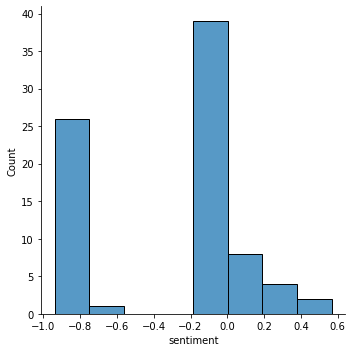

In [411]:
import seaborn as sns
sns.displot(tmp_df.sentiment)

In [406]:
tmp_df

,created_at,author_id,text,id,sentiment
0,2021-08-18 07:12:38+00:00,1245033589260947456,RT @iKON_INTL: [Stan World Event]\n\nHello iKO...,1427891168025534467,-0.9375
1,2021-08-18 07:12:32+00:00,975723499175186432,Hello World (1629270750),1427891145028210690,0.0000
2,2021-08-18 07:12:30+00:00,400097142,RT @iKON_INTL: [Stan World Event]\n\nHello iKO...,1427891135687630856,-0.9375
3,2021-08-18 07:12:23+00:00,1202240071690096640,RT @iKON_INTL: [Stan World Event]\n\nHello iKO...,1427891106478321667,-0.9375
4,2021-08-18 07:12:19+00:00,1273865081554522113,"RT @arjeniaxggone: Hello, everyone! 😍 Since Ki...",1427891088912621573,0.0000
...,...,...,...,...,...
75,2021-08-18 07:00:49+00:00,442912341,"RT @slimzytuks: Hello everyone,\n\nYourYoursTr...",1427888196893958150,-0.0500
76,2021-08-18 07:00:32+00:00,1393605512277610503,RT @AcctDiary: Hello A’TIN! \n\nPlease read Fr...,1427888125330681857,-0.0125
77,2021-08-18 07:00:29+00:00,1409393627873177604,Hello mga taga bluebird world\n\nSB19 onSRANWO...,1427888111346884610,0.0000
78,2021-08-18 06:58:46+00:00,1427870025419919367,Hello World!,1427887682126974977,0.0000


Now got all the information requested by the task, need to visualize and continuously fetch new data to updata numbers...

### Probably some tokens that should be removed....

In [329]:
text = TextBlob('\n'.join(df_tweets.iloc[1:3].text))

In [333]:
for sentence in text:
    print(sentence)

R
T
 
@
S
c
o
t
t
H
e
c
h
:
 
O
k
a
y
 
g
r
e
a
t
 
*
b
u
t
 
o
n
l
y
 
1
0
!
!
!
!
!
?
?
?
?
?
 
S
h
o
u
l
d
 
b
e
 
t
h
o
u
s
a
n
d
s
.


@
S
k
z
H
y
u
n
j
i
n
S
t
a
y
8
 
H
A
P
P
Y
 
B
I
R
T
H
D
A
Y
 
S
K
Y
🥳
❤
️
H
o
p
e
 
y
o
u
 
h
a
v
e
 
a
 
g
r
e
a
t
 
d
a
y
 
🕺
🏾
🥳
!


In [330]:
text.sentiment

Sentiment(polarity=0.62, subjectivity=0.8)

In [331]:
text

TextBlob("RT @ScottHech: Okay great *but only 10!!!!!????? Should be thousands.
@SkzHyunjinStay8 HAPPY BIRTHDAY SKY🥳❤️Hope you have a great day 🕺🏾🥳!")

In [259]:
text.sentiment

Sentiment(polarity=0.35, subjectivity=0.65)

In [3]:
api = authorize_twitter_api()

In [4]:
class MyStreamListener(tweepy.StreamListener):
    
    def on_status(self, status):
        print(status.text)
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_error disconnects the stream
            return False

In [18]:
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)

In [21]:
tweets = []
for page in tweepy.Cursor(api.search, q='hello', count=100, result_type="recent",tweet_mode='extended').pages(10):
    tweets.extend([status._json for status in page])

Rate limit reached. Sleeping for: 256


KeyboardInterrupt: 

In [22]:
import requests
import os
import json